# Data retrival with Pyrocko

In this notebook, we will use Pyrocko to retrieve data from the FDSN services via script. [Documentation](https://pyrocko.org/docs/current/library/reference/client/waveform.html)

Reference: https://pyrocko.org/docs/current/library/examples/fdsn_download.html

In [1]:
import matplotlib.pyplot as plt

from pyrocko.client import fdsn
from pyrocko import util, io, trace, model
from pyrocko.io import quakeml

# Events
First, we use pyrocko to get events. For that we need to define a time range and a service which has an available 'event'-option, e.g. IRIS or GFZ. The time refers to the origin time of the event, not if signal arrives at a certain station from an event.


In [9]:
tmin = util.stt('2014-01-01 16:10:00.000')
tmax = util.stt('2014-01-01 16:39:59.000')

# request events at IRIS for the given time span
request_event = fdsn.event(
    site='iris', starttime=tmin, endtime=tmax)

# parse QuakeML and extract pyrocko events
events = quakeml.QuakeML.load_xml(request_event).get_pyrocko_events()

# If wanted, one can easily store the events:
# model.dump_events(events, 'iris-events.pf')

In [10]:
for event in events:
    print(event)

--- !pf.Event
lat: 45.75
lon: 146.73
time: '2014-01-01 16:39:17.5'
depth: 305000.0
name: 'smi:service.iris.edu/fdsnws/event/1/query?originid=19565360'
magnitude: 3.1
magnitude_type: ''
region: 'KURIL ISLANDS'

--- !pf.Event
lat: 43.3933
lon: 12.5038
time: '2014-01-01 16:37:43.210000038'
depth: 6600.0
name: 'smi:service.iris.edu/fdsnws/event/1/query?originid=19565359'
magnitude: 1.1
magnitude_type: 'Md'
region: 'CENTRAL ITALY'

--- !pf.Event
lat: 34.965
lon: 23.5233
time: '2014-01-01 16:34:25.180000067'
depth: 33900.0
name: 'smi:service.iris.edu/fdsnws/event/1/query?originid=19565358'
magnitude: 2.3
magnitude_type: 'ML'
region: 'CRETE, GREECE'

--- !pf.Event
lat: 36.69
lon: 140.64
time: '2014-01-01 16:33:00.5'
depth: 5000.0
name: 'smi:service.iris.edu/fdsnws/event/1/query?originid=19565357'
magnitude: 2.2
magnitude_type: ''
region: 'NEAR EAST COAST OF HONSHU, JAPAN'

--- !pf.Event
lat: 34.67
lon: 136.58
time: '2014-01-01 16:32:35.200000048'
depth: 15000.0
name: 'smi:service.iris.edu/fds

### Tasks:
- try different services and time ranges

# Waveforms
Similar to the event, we also need a service and time, but additional information about the stations. The basic code behind a station name is the NSLC, meaning "Network.Station.Location.Channel".

In [34]:
tmin = util.stt('2014-01-01 16:10:00.000')
tmax = util.stt('2014-01-01 16:39:59.000')

# select stations by their NSLC id and wildcards (asterisk) for waveform download
selection = [
    ('*', 'HMDT', '*', '*', tmin, tmax),    # all available components
    ('GE', 'EIL', '*', '*Z', tmin, tmax),   # all vertical components
]

# Restricted access token
# token = open('token.asc', 'rb').read()
# request_waveform = fdsn.dataselect(site='geofon', selection=selection,
#                                    token=token)

# setup a waveform data request
request_waveform = fdsn.dataselect(site='geofon', selection=selection)

#### is there another way of showing the traces? instead of savin and reloading them?

# write the incoming data stream to 'traces.mseed'
with open('traces.mseed', 'wb') as file:
    file.write(request_waveform.read())

In [23]:
traces = io.load('traces.mseed')
for tr in traces:
    print(tr)

Trace (IS, HMDT, , SHE)
  timerange: 2014-01-01 16:09:57.10 - 2014-01-01 16:39:59.60
  delta t: 0.025

Trace (IS, HMDT, , SHN)
  timerange: 2014-01-01 16:09:55.65 - 2014-01-01 16:39:59.78
  delta t: 0.025

Trace (IS, HMDT, , SHZ)
  timerange: 2014-01-01 16:09:51.58 - 2014-01-01 16:40:07.10
  delta t: 0.025

Trace (GE, EIL, , SHZ)
  timerange: 2014-01-01 16:09:51.20 - 2014-01-01 16:40:02.18
  delta t: 0.02

Trace (GE, EIL, , LHZ)
  timerange: 2014-01-01 16:09:26 - 2014-01-01 16:40:19
  delta t: 1

Trace (GE, EIL, , BHZ)
  timerange: 2014-01-01 16:09:43.35 - 2014-01-01 16:40:05.30
  delta t: 0.05

Trace (GE, EIL, , LLZ)
  timerange: 2014-01-01 16:09:26 - 2014-01-01 16:40:19
  delta t: 1

Trace (GE, EIL, , BLZ)
  timerange: 2014-01-01 16:09:27.35 - 2014-01-01 16:40:03.30
  delta t: 0.05



# Station data
Pretty similar to the waveform retrieval.

In [26]:
tmin = util.stt('2014-01-01 16:10:00.000')
tmax = util.stt('2014-01-01 16:39:59.000')

# select stations by their NSLC id and wildcards (asterisk) for waveform download
selection = [
    ('*', 'HMDT', '*', '*', tmin, tmax),    # all available components
    ('GE', 'EIL', '*', '*Z', tmin, tmax),   # all vertical components
]

# request meta data
request_response = fdsn.station(
    site='geofon', selection=selection, level='response')

# save the response in YAML and StationXML format
request_response.dump(filename='responses_geofon.yaml')
request_response.dump_xml(filename='responses_geofon.xml')

# Combining
Download waveform, do a response correction

In [33]:
service = 'geofon'

tmin = util.stt('2014-01-01 16:10:00.000')
tmax = util.stt('2014-01-01 16:39:59.000')

# select stations by their NSLC id and wildcards (asterisk) for waveform download
selection = [
    ('*', 'HMDT', '*', '*', tmin, tmax),    # all available components
    ('GE', 'EIL', '*', '*Z', tmin, tmax),   # all vertical components
]

request_waveform = fdsn.dataselect(site=service, selection=selection)

#### is there another way of showing the traces? instead of savin and reloading them?
# write the incoming data stream to 'traces.mseed'
with open('traces2.mseed', 'wb') as file:
    file.write(request_waveform.read())

request_response = fdsn.station(
    site=service, selection=selection, level='response')

# Loop through retrieved waveforms and request meta information for each trace
traces = io.load('traces2.mseed')
displacement = []
for tr in traces:
    polezero_response = request_response.get_pyrocko_response(
        nslc=tr.nslc_id,
        timespan=(tr.tmin, tr.tmax),
        fake_input_units='M')
    # *fake_input_units*: required for consistent responses throughout entire
    # data set

    # deconvolve transfer function
    restituted = tr.transfer(
        tfade=2.,
        freqlimits=(0.01, 0.1, 1., 2.),
        transfer_function=polezero_response,
        invert=True)

    displacement.append(restituted)

Instrument sensitivity value inconsistent with sensitivity computed from complete response
  channel: IS.HMDT..SHE
  reported value: 3.14195e+08
  computed value: 3.09321e+08
  at frequency [Hz]: 0.02
  difference [dB]: -0.135818
  limit [dB]: 0.1
Instrument sensitivity value inconsistent with sensitivity computed from complete response
  channel: IS.HMDT..SHN
  reported value: 3.14195e+08
  computed value: 3.09321e+08
  at frequency [Hz]: 0.02
  difference [dB]: -0.135818
  limit [dB]: 0.1
Instrument sensitivity value inconsistent with sensitivity computed from complete response
  channel: IS.HMDT..SHZ
  reported value: 3.14195e+08
  computed value: 3.09321e+08
  at frequency [Hz]: 0.02
  difference [dB]: -0.135818
  limit [dB]: 0.1


In [29]:
# Inspect waveforms using Snuffler
trace.snuffle(displacement)

ModuleNotFoundError: No module named 'PyQt4'

[<pyrocko.trace.Trace object at 0x7fe8b5565250>, <pyrocko.trace.Trace object at 0x7fe8b55654c0>, <pyrocko.trace.Trace object at 0x7fe8b5623c40>, <pyrocko.trace.Trace object at 0x7fe8b62e0ac0>, <pyrocko.trace.Trace object at 0x7fe8b5623df0>, <pyrocko.trace.Trace object at 0x7fe8b5623fa0>, <pyrocko.trace.Trace object at 0x7fe8b55653d0>, <pyrocko.trace.Trace object at 0x7fe8b62e0c70>]


<Figure size 1152x648 with 0 Axes>

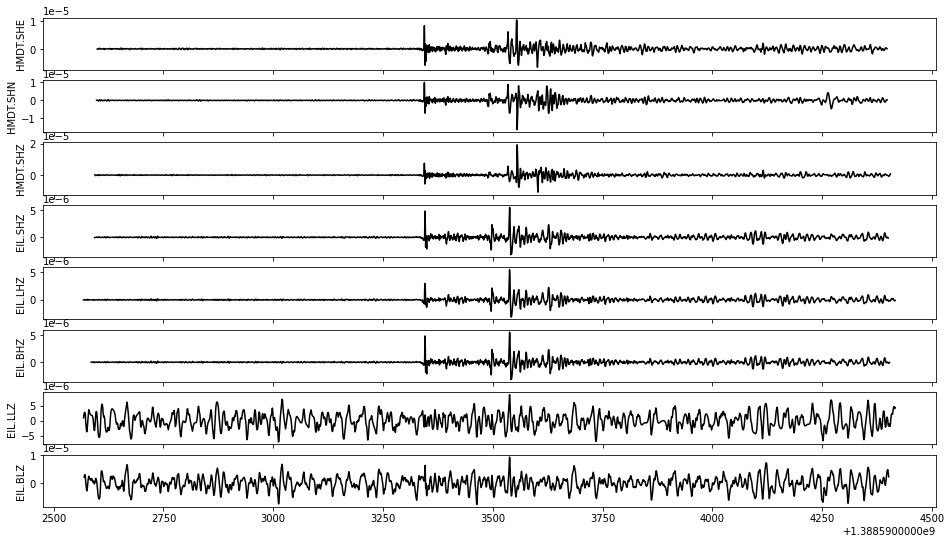

In [32]:
print(displacement)
plt.figure(figsize=(16,9))
f, ax = plt.subplots(len(displacement), 1, sharex=True, figsize=(16,9))
for cnt, tr in enumerate(displacement):
    ax[cnt].plot(tr.get_xdata(), tr.ydata, color='k')
    ax[cnt].set_ylabel('%s.%s' % (tr.station, tr.channel))
plt.show()

# With snuffler